In [1]:
import keras
from keras import regularizers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.callbacks import ModelCheckpoint

# sklearn
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Other  
import librosa
import librosa.display
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import seaborn as sns
import glob 
import os
from tqdm import tqdm
import pickle
import IPython.display as ipd

In [2]:
def noise(data):
    
    # you can take any distribution from https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.random.html
    noise_amp = 0.05*np.random.uniform()*np.amax(data)   # more noise reduce the value to 0.5
    data = data.astype('float64') + noise_amp * np.random.normal(size=data.shape[0])
    return data
    
def shift(data):
   
    s_range = int(np.random.uniform(low=-5, high = 5)*1000)  #default at 500
    return np.roll(data, s_range)
    
def stretch(data, rate=0.8):
    
    data = librosa.effects.time_stretch(data, rate)
    return data
    
def pitch(data, sample_rate):

    bins_per_octave = 12
    pitch_pm = 2
    pitch_change =  pitch_pm * 2*(np.random.uniform())   
    data = librosa.effects.pitch_shift(data.astype('float64'), 
                                      sample_rate, n_steps=pitch_change, 
                                      bins_per_octave=bins_per_octave)
    return data
    
def dyn_change(data):

    dyn_change = np.random.uniform(low=-0.5 ,high=7)  # default low = 1.5, high = 3
    return (data * dyn_change)
    
def speedNpitch(data):

    # you can change low and high here
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.2  / length_change # try changing 1.0 to 2.0 ... =D
    tmp = np.interp(np.arange(0,len(data),speed_fac),np.arange(0,len(data)),data)
    minlen = min(data.shape[0], tmp.shape[0])
    data *= 0
    data[0:minlen] = tmp[0:minlen]
    return data

def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [3]:
ref = pd.read_csv("data.csv")
ref = ref.loc[:, ~ref.columns.str.contains('^Unnamed')]
ref.head()

,labels,path
0,male_angry,AudioWAV/1001_DFA_ANG_XX.wav
1,male_disgust,AudioWAV/1001_DFA_DIS_XX.wav
2,male_fear,AudioWAV/1001_DFA_FEA_XX.wav
3,male_happy,AudioWAV/1001_DFA_HAP_XX.wav
4,male_neutral,AudioWAV/1001_DFA_NEU_XX.wav


In [4]:
ref

,labels,path
0,male_angry,AudioWAV/1001_DFA_ANG_XX.wav
1,male_disgust,AudioWAV/1001_DFA_DIS_XX.wav
2,male_fear,AudioWAV/1001_DFA_FEA_XX.wav
3,male_happy,AudioWAV/1001_DFA_HAP_XX.wav
4,male_neutral,AudioWAV/1001_DFA_NEU_XX.wav
...,...,...
7437,female_disgust,AudioWAV/1091_WSI_DIS_XX.wav
7438,female_fear,AudioWAV/1091_WSI_FEA_XX.wav
7439,female_happy,AudioWAV/1091_WSI_HAP_XX.wav
7440,female_neutral,AudioWAV/1091_WSI_NEU_XX.wav


In [6]:
df = pd.DataFrame(columns=['feature'])
df_noise = pd.DataFrame(columns=['feature'])
df_speedpitch = pd.DataFrame(columns=['feature'])
cnt = 0

for i in tqdm(ref.path):
    
    X, sample_rate = librosa.load(i
                                  ,duration=2.5
                                  ,sr=44100
                                  ,offset=0.5
                                 )

    # take mfcc and mean as the feature. Could do min and max etc as well. 
    mfccs = np.mean(librosa.feature.mfcc(y=X, 
                                        sr=np.array(sample_rate), 
                                        n_mfcc=13),
                    axis=0)
    
    df.loc[cnt] = [mfccs]   

 
    aug = noise(X)
    aug = np.mean(librosa.feature.mfcc(y=aug, 
                                    sr=np.array(sample_rate), 
                                    n_mfcc=13),    
                  axis=0)
    df_noise.loc[cnt] = [aug]

    aug = speedNpitch(X)
    aug = np.mean(librosa.feature.mfcc(y=aug, 
                                    sr=np.array(sample_rate), 
                                    n_mfcc=13),    
                  axis=0)
    df_speedpitch.loc[cnt] = [aug]   

    cnt += 1

df.head()

100%|██████████████████████████████████████████████████████████████████████████████| 7442/7442 [05:22<00:00, 23.11it/s]


,feature
0,"[-5.2508473, -6.221631, -12.729986, -14.100443..."
1,"[-24.977274, -22.91568, -21.271679, -19.676529..."
2,"[-24.57367, -22.223755, -19.399227, -22.226105..."
3,"[-18.51954, -15.073533, -15.772251, -15.432199..."
4,"[-11.942498, -13.092902, -18.679506, -19.98022..."


In [7]:
df = pd.concat([ref,pd.DataFrame(df['feature'].values.tolist())],axis=1)
df_noise = pd.concat([ref,pd.DataFrame(df_noise['feature'].values.tolist())],axis=1)
df_speedpitch = pd.concat([ref,pd.DataFrame(df_speedpitch['feature'].values.tolist())],axis=1)
print(df.shape,df_noise.shape,df_speedpitch.shape)

(7442, 218) (7442, 218) (7442, 218)


In [8]:
df = pd.concat([df,df_noise,df_speedpitch],axis=0,sort=False)
df=df.fillna(0)
del df_noise, df_speedpitch

np.random.seed(42)

X_train, X_test, y_train, y_test = train_test_split(df.drop(['path','labels'],axis=1)
                                                    , df.labels
                                                    , test_size=0.25
                                                    , shuffle=True
                                                   )
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
3883,-18.751121,-16.299174,-16.167529,-15.055659,-14.492952,-14.038423,-14.249863,-14.412050,-16.431659,-16.771274,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3520,-21.778212,-18.666857,-19.252398,-19.875721,-18.994389,-18.321186,-18.971230,-19.643097,-21.092674,-20.258694,...,-55.714523,-55.714523,-55.714523,-55.714523,-55.714523,-55.714523,-55.714523,-55.714523,-55.714523,-55.714523
4201,-19.449375,-16.894199,-14.938455,-13.813752,-16.176357,-16.903166,-16.188824,-18.584698,-17.880728,-16.768494,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6384,-16.893379,-13.663303,-12.355535,-12.496924,-12.108475,-11.891023,-12.388429,-13.577755,-14.054605,-15.606861,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3449,-15.573391,-14.871859,-15.157110,-14.945130,-13.807349,-14.552736,-14.028005,-12.835922,-13.009629,-14.535007,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [9]:
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

In [10]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [11]:
import np_utils
from keras.utils import to_categorical


lb = LabelEncoder()
y_train = keras.utils.to_categorical(lb.fit_transform(y_train))
y_test = keras.utils.to_categorical(lb.fit_transform(y_test))

In [12]:
y_train.shape

(16744, 12)

In [13]:
print(X_train.shape)
print(lb.classes_)

filename = 'labels'
outfile = open(filename,'wb')
pickle.dump(lb,outfile)
outfile.close()

(16744, 216)
['female_angry' 'female_disgust' 'female_fear' 'female_happy'
 'female_neutral' 'female_sad' 'male_angry' 'male_disgust' 'male_fear'
 'male_happy' 'male_neutral' 'male_sad']


In [14]:
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_train.shape

(16744, 216, 1)

In [15]:
model = Sequential()
model.add(Conv1D(256, 8, padding='same',input_shape=(X_train.shape[1],1)))  # X_train.shape[1] = No. of Columns
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(12)) # Target class number
model.add(Activation('softmax'))
opt = keras.optimizers.legacy.RMSprop(lr=0.00001, decay=1e-6)
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 216, 256)          2304      
                                                                 
 activation (Activation)     (None, 216, 256)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 216, 256)          524544    
                                                                 
 batch_normalization (Batch  (None, 216, 256)          1024      
 Normalization)                                                  
                                                                 
 activation_1 (Activation)   (None, 216, 256)          0         
                                                                 
 dropout (Dropout)           (None, 216, 256)          0         
                                                      

C:\Users\sanke\anaconda3\lib\site-packages\keras\src\optimizers\legacy\rmsprop.py:144: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [16]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
model_history=model.fit(X_train, y_train, batch_size=16, epochs=150, validation_data=(X_test, y_test),verbose=2)


Epoch 1/150


1047/1047 - 105s - loss: 2.3590 - accuracy: 0.1696 - val_loss: 2.3248 - val_accuracy: 0.1935 - 105s/epoch - 101ms/step
Epoch 2/150
1047/1047 - 99s - loss: 2.2216 - accuracy: 0.2124 - val_loss: 2.2582 - val_accuracy: 0.2148 - 99s/epoch - 94ms/step
Epoch 3/150
1047/1047 - 98s - loss: 2.1565 - accuracy: 0.2341 - val_loss: 2.1919 - val_accuracy: 0.2352 - 98s/epoch - 93ms/step
Epoch 4/150
1047/1047 - 97s - loss: 2.1171 - accuracy: 0.2557 - val_loss: 2.1816 - val_accuracy: 0.2313 - 97s/epoch - 93ms/step
Epoch 5/150
1047/1047 - 97s - loss: 2.0872 - accuracy: 0.2634 - val_loss: 2.1683 - val_accuracy: 0.2488 - 97s/epoch - 93ms/step
Epoch 6/150
1047/1047 - 97s - loss: 2.0688 - accuracy: 0.2711 - val_loss: 2.1697 - val_accuracy: 0.2367 - 97s/epoch - 92ms/step
Epoch 7/150
1047/1047 - 97s - loss: 2.0513 - accuracy: 0.2741 - val_loss: 2.1247 - val_accuracy: 0.2603 - 97s/epoch - 93ms/step
Epoch 8/150
1047/1047 - 97s - loss: 2.0358 - accuracy: 0.2811 - val_loss: 2.1455 - val_accuracy: 0.

Epoch 61/150
1047/1047 - 97s - loss: 1.5231 - accuracy: 0.4728 - val_loss: 2.0000 - val_accuracy: 0.2829 - 97s/epoch - 93ms/step
Epoch 62/150
1047/1047 - 97s - loss: 1.5044 - accuracy: 0.4797 - val_loss: 2.0204 - val_accuracy: 0.2886 - 97s/epoch - 92ms/step
Epoch 63/150
1047/1047 - 96s - loss: 1.4954 - accuracy: 0.4886 - val_loss: 1.9733 - val_accuracy: 0.3019 - 96s/epoch - 92ms/step
Epoch 64/150
1047/1047 - 97s - loss: 1.4844 - accuracy: 0.4870 - val_loss: 2.0490 - val_accuracy: 0.2786 - 97s/epoch - 93ms/step
Epoch 65/150
1047/1047 - 97s - loss: 1.4713 - accuracy: 0.4967 - val_loss: 2.0016 - val_accuracy: 0.2902 - 97s/epoch - 93ms/step
Epoch 66/150
1047/1047 - 96s - loss: 1.4615 - accuracy: 0.5030 - val_loss: 2.0178 - val_accuracy: 0.2888 - 96s/epoch - 92ms/step
Epoch 67/150
1047/1047 - 98s - loss: 1.4588 - accuracy: 0.4930 - val_loss: 2.1372 - val_accuracy: 0.2526 - 98s/epoch - 94ms/step
Epoch 68/150
1047/1047 - 97s - loss: 1.4476 - accuracy: 0.5043 - val_loss: 2.0313 - val_accuracy:

Epoch 125/150
1047/1047 - 97s - loss: 0.8576 - accuracy: 0.7054 - val_loss: 2.0945 - val_accuracy: 0.3029 - 97s/epoch - 93ms/step
Epoch 126/150
1047/1047 - 97s - loss: 0.8475 - accuracy: 0.7113 - val_loss: 2.1467 - val_accuracy: 0.3037 - 97s/epoch - 93ms/step
Epoch 127/150
1047/1047 - 96s - loss: 0.8343 - accuracy: 0.7172 - val_loss: 2.0275 - val_accuracy: 0.3209 - 96s/epoch - 92ms/step
Epoch 128/150
1047/1047 - 97s - loss: 0.8265 - accuracy: 0.7220 - val_loss: 2.1178 - val_accuracy: 0.3103 - 97s/epoch - 92ms/step
Epoch 129/150
1047/1047 - 97s - loss: 0.8253 - accuracy: 0.7154 - val_loss: 2.1496 - val_accuracy: 0.3092 - 97s/epoch - 93ms/step
Epoch 130/150
1047/1047 - 96s - loss: 0.8141 - accuracy: 0.7245 - val_loss: 2.0672 - val_accuracy: 0.3183 - 96s/epoch - 92ms/step
Epoch 131/150
1047/1047 - 97s - loss: 0.8008 - accuracy: 0.7249 - val_loss: 2.0575 - val_accuracy: 0.3255 - 97s/epoch - 92ms/step
Epoch 132/150
1047/1047 - 97s - loss: 0.8004 - accuracy: 0.7269 - val_loss: 2.0646 - val_a

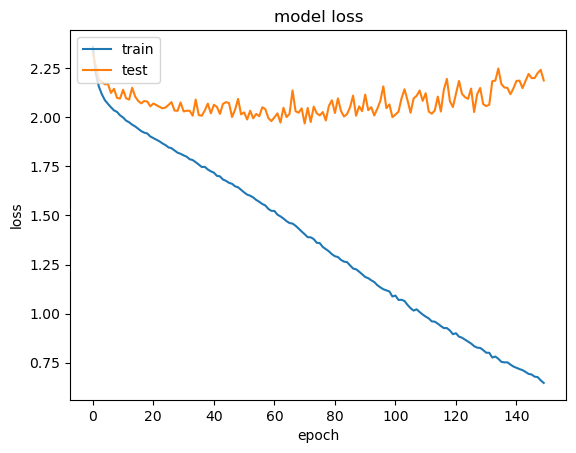

In [17]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Saving the model

In [19]:
import pickle

fname = 'final_model1.sav'

pickle.dump(model,open(fname,'wb'))

In [21]:
preds = model.predict(X_test, 
                         batch_size=16, 
                         verbose=1)

preds=preds.argmax(axis=1)
preds

349/349 [==============================] - 6s 16ms/step


array([1, 2, 2, ..., 2, 2, 5], dtype=int64)

In [22]:
preds = preds.astype(int).flatten()
preds = (lb.inverse_transform((preds)))
preds = pd.DataFrame({'predictedvalues': preds})


actual=y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'actualvalues': actual})

finaldf = actual.join(preds)

In [23]:
finaldf

,actualvalues,predictedvalues
0,female_disgust,female_disgust
1,female_sad,female_fear
2,male_sad,female_fear
3,male_fear,male_happy
4,female_happy,female_fear
...,...,...
5577,female_disgust,female_fear
5578,male_disgust,female_disgust
5579,female_sad,female_fear
5580,female_angry,female_fear


In [24]:
finaldf[finaldf['actualvalues'] == finaldf['predictedvalues']]

,actualvalues,predictedvalues
0,female_disgust,female_disgust
6,female_happy,female_happy
11,male_disgust,male_disgust
12,female_fear,female_fear
13,female_sad,female_sad
...,...,...
5564,male_fear,male_fear
5567,female_happy,female_happy
5568,female_angry,female_angry
5573,female_neutral,female_neutral


In [25]:
finaldf.to_csv('Predictions.csv',index=False)
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
female_angry,408
female_disgust,190
female_fear,1195
female_happy,818
female_neutral,271
female_sad,618
male_angry,412
male_disgust,209
male_fear,363


0.32246506628448585


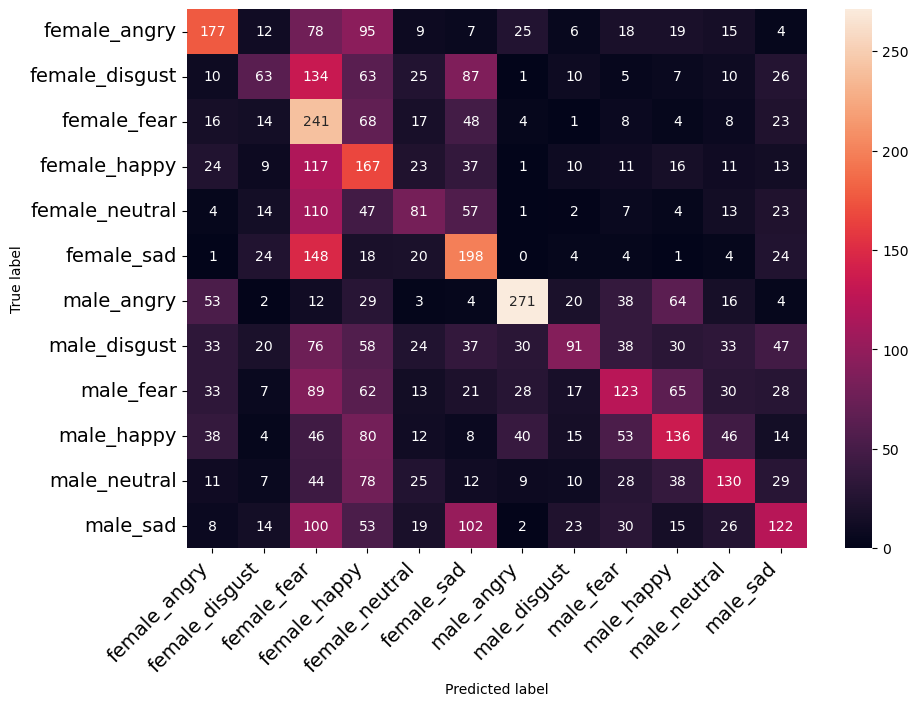

In [26]:
finaldf = pd.read_csv("Predictions.csv")
classes = finaldf.actualvalues.unique()
classes.sort()    
 
c = confusion_matrix(finaldf.actualvalues, finaldf.predictedvalues)
print(accuracy_score(finaldf.actualvalues, finaldf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

In [27]:
classes = finaldf.actualvalues.unique()
classes.sort()    
print(classification_report(finaldf.actualvalues, finaldf.predictedvalues, target_names=classes))

                precision    recall  f1-score   support

  female_angry       0.43      0.38      0.41       465
female_disgust       0.33      0.14      0.20       441
   female_fear       0.20      0.53      0.29       452
  female_happy       0.20      0.38      0.27       439
female_neutral       0.30      0.22      0.26       363
    female_sad       0.32      0.44      0.37       446
    male_angry       0.66      0.53      0.58       516
  male_disgust       0.44      0.18      0.25       517
     male_fear       0.34      0.24      0.28       516
    male_happy       0.34      0.28      0.31       492
  male_neutral       0.38      0.31      0.34       421
      male_sad       0.34      0.24      0.28       514

      accuracy                           0.32      5582
     macro avg       0.36      0.32      0.32      5582
  weighted avg       0.36      0.32      0.32      5582



In [28]:
classes = modidf.actualvalues.unique()
classes.sort()    
print(classification_report(modidf.actualvalues, modidf.predictedvalues, target_names=classes))

NameError: name 'modidf' is not defined

0.4057685417413114


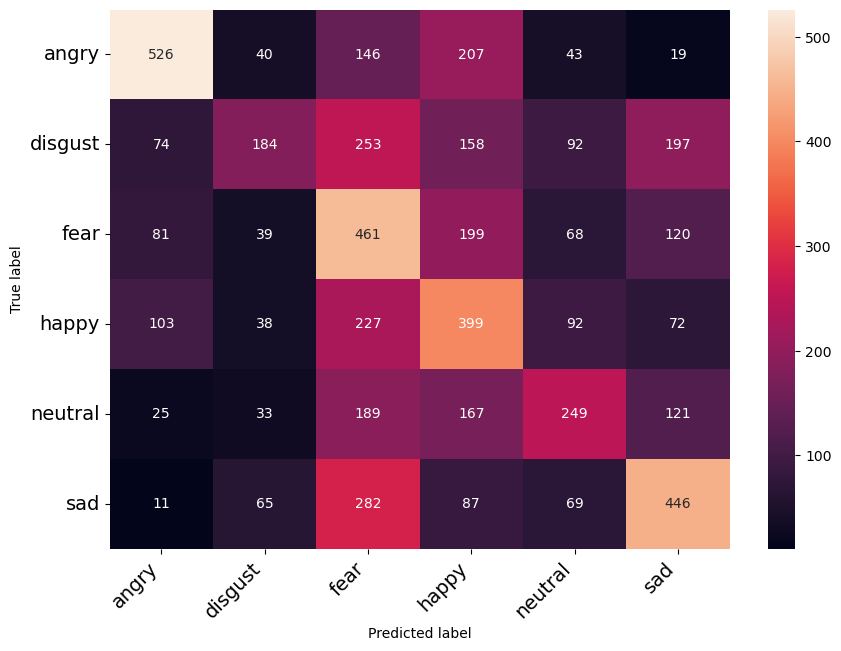

In [29]:
modidf = pd.read_csv("Predictions.csv")
modidf['actualvalues'] = modidf.actualvalues.replace({'female_angry':'angry'
                                       , 'female_disgust':'disgust'
                                       , 'female_fear':'fear'
                                       , 'female_happy':'happy'
                                       , 'female_sad':'sad'
                                       , 'female_surprise':'surprise'
                                       , 'female_neutral':'neutral'
                                       , 'male_angry':'angry'
                                       , 'male_fear':'fear'
                                       , 'male_happy':'happy'
                                       , 'male_sad':'sad'
                                       , 'male_surprise':'surprise'
                                       , 'male_neutral':'neutral'
                                       , 'male_disgust':'disgust'
                                      })

modidf['predictedvalues'] = modidf.predictedvalues.replace({'female_angry':'angry'
                                       , 'female_disgust':'disgust'
                                       , 'female_fear':'fear'
                                       , 'female_happy':'happy'
                                       , 'female_sad':'sad'
                                       , 'female_surprise':'surprise'
                                       , 'female_neutral':'neutral'
                                       , 'male_angry':'angry'
                                       , 'male_fear':'fear'
                                       , 'male_happy':'happy'
                                       , 'male_sad':'sad'
                                       , 'male_surprise':'surprise'
                                       , 'male_neutral':'neutral'
                                       , 'male_disgust':'disgust'
                                      })

classes = modidf.actualvalues.unique() 
classes.sort() 

c = confusion_matrix(modidf.actualvalues, modidf.predictedvalues)
print(accuracy_score(modidf.actualvalues, modidf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

In [30]:
#function to be used to get predictions
def pred(file):
    X, sample_rate = librosa.load(file
                              ,duration=2.5
                              ,sr=44100
                              ,offset=0.5
                             )

    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13),axis=0)
    newdf = pd.DataFrame(data=mfccs).T
    
    for i in range(len(newdf.columns),216):
        newdf[f'{i}'] = 0
        
    newdf= np.expand_dims(newdf, axis=2)
    newpred = newnew.predict(newdf, 
                         batch_size=16, 
                         verbose=1)

        
    filename = 'labels'
    infile = open(filename,'rb')
    lb = pickle.load(infile)
    infile.close()

    final = newpred.argmax(axis=1)
    final = final.astype(int).flatten()
    final = (lb.inverse_transform((final)))
    return final